# マルチモーダル検索（e-コマース）のデモノートブック
埋め込みモデル：Cohere Embed Multilingual v 3.0

In [1]:
import cohere
from PIL import Image
from io import BytesIO
import base64
import os
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from pathlib import Path
from tqdm import tqdm

In [2]:
_= load_dotenv(find_dotenv())
api_key = os.getenv("COHERE_API_KEY")

## 画像の埋め込み生成

In [3]:
co = cohere.Client(api_key=api_key)

### 画像をData URLに変換する関数を定義

In [4]:
def image_to_base64_data_url(image_path):
    with Image.open(image_path) as img:
        buffered = BytesIO()
        img.save(buffered, format="PNG")
        img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")
    # PNG に変換したので画像フォーマットは PNG と決め打ち
    data_url = f"data:image/png;base64,{img_base64}"
    return data_url

### 埋め込み処理対象の画像を定義

In [5]:
image_paths = []
image_paths.extend(Path("ecimages/Footwear/Men/Images/images_with_product_ids").glob("*.jpg"))
image_paths.extend(Path("ecimages/Footwear/Women/Images/images_with_product_ids").glob("*.jpg"))

In [6]:
len(image_paths)
print(image_paths[:10])

[WindowsPath('ecimages/Footwear/Men/Images/images_with_product_ids/10037.jpg'), WindowsPath('ecimages/Footwear/Men/Images/images_with_product_ids/10039.jpg'), WindowsPath('ecimages/Footwear/Men/Images/images_with_product_ids/10097.jpg'), WindowsPath('ecimages/Footwear/Men/Images/images_with_product_ids/10174.jpg'), WindowsPath('ecimages/Footwear/Men/Images/images_with_product_ids/10180.jpg'), WindowsPath('ecimages/Footwear/Men/Images/images_with_product_ids/10266.jpg'), WindowsPath('ecimages/Footwear/Men/Images/images_with_product_ids/10267.jpg'), WindowsPath('ecimages/Footwear/Men/Images/images_with_product_ids/10268.jpg'), WindowsPath('ecimages/Footwear/Men/Images/images_with_product_ids/10293.jpg'), WindowsPath('ecimages/Footwear/Men/Images/images_with_product_ids/10294.jpg')]


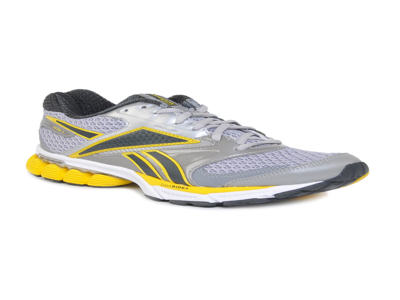

In [7]:
display(Image.open(image_paths[0]).resize((400,300)))

### 画像の埋め込み生成の実行

In [8]:
import h5py
import os
import numpy as np
import gc  # ガベージコレクションを明示的に呼び出すために追加

# embeddings フォルダが存在しない場合は作成
os.makedirs('embeddings', exist_ok=True)

# 保存先のファイルパス
output_file = 'embeddings/ecommerce_embeddings.h5'

# 既存のファイルから処理済み画像のパスを取得
processed_paths = set()
next_id = 0
embedding_dim = 0

In [9]:
print("既存データの確認中...")

# ファイルが既に存在する場合は処理済みのパスを processed_paths に読み込む
if os.path.exists(output_file):
    try:
        with h5py.File(output_file, 'r') as f:
            if 'paths' in f and 'embeddings' in f:
                # 少しずつ読み込んでメモリ使用量を抑える
                chunk_size = 1000
                total_items = f['paths'].shape[0]
                
                for i in range(0, total_items, chunk_size):
                    end_idx = min(i + chunk_size, total_items)
                    paths_chunk = f['paths'][i:end_idx]
                    
                    for p in paths_chunk:
                        if isinstance(p, bytes):
                            processed_paths.add(p.decode('utf-8'))
                        else:
                            processed_paths.add(str(p))
                
                next_id = len(f['ids'])
                embedding_dim = f['embeddings'].shape[1]
                print(f"既存ファイルから{next_id}件のデータを読み込みました")
                if processed_paths:
                    print(f"処理済みパス例: {list(processed_paths)[0]}")
    except Exception as e:
        print(f"既存ファイル読み込み中にエラーが発生しました: {e}")
        # ファイルが破損している場合は新規作成する
        if os.path.exists(output_file):
            print("既存ファイルをバックアップし、新規作成します")
            os.rename(output_file, f"{output_file}.bak")
            next_id = 0
            processed_paths = set()

# メモリ解放
gc.collect()

既存データの確認中...
既存ファイルから1580件のデータを読み込みました
処理済みパス例: ecimages\Footwear\Women\Images\images_with_product_ids\57854.jpg


0

In [10]:
# 未処理の画像パスをフィルタリング
new_image_paths = []
for path in image_paths:
    path_str = str(path)
    if path_str not in processed_paths:
        new_image_paths.append(path)

print(f"新規処理対象: {len(new_image_paths)}件 / 全体: {len(image_paths)}件")

if not new_image_paths:
    print("新しく処理する画像はありません")
else:
    # 埋め込みの次元数を最初の画像で確認
    if embedding_dim == 0 and new_image_paths:
        try:
            print("最初の画像から埋め込みサイズを取得中...")
            first_image = image_to_base64_data_url(new_image_paths[0])
            first_embedding = co.embed(
                images=[first_image],
                input_type="image",
                model="embed-multilingual-v3.0",
                embedding_types=["float"],
            ).embeddings.float[0]
            embedding_dim = len(first_embedding)
            print(f"埋め込みの次元数: {embedding_dim}")
            
            # メモリ解放
            del first_image, first_embedding
            gc.collect()
        except Exception as e:
            print(f"埋め込みサイズ取得中にエラーが発生しました: {e}")
            print("デフォルト値を使用します")
            embedding_dim = 1024  # 一般的な埋め込みサイズの例

    # ファイルモードを決定（新規作成または追加）
    file_mode = 'a' if os.path.exists(output_file) else 'w'
    print(f"ファイルを{file_mode}モードで開きます: {output_file}")

    try:
        # HDF5ファイルを開く
        with h5py.File(output_file, file_mode) as f:
            # 新規作成の場合はデータセットを作成
            if file_mode == 'w':
                # 文字列用のデータ型を設定
                dt = h5py.special_dtype(vlen=str)
                
                # 初期サイズを小さくして、徐々に拡張する
                initial_size = min(100, len(new_image_paths))
                
                paths_dataset = f.create_dataset('paths', shape=(initial_size,), 
                                                maxshape=(None,), dtype=dt)
                
                # 埋め込み用のデータセット
                embeddings_dataset = f.create_dataset('embeddings', 
                                                    shape=(initial_size, embedding_dim), 
                                                    maxshape=(None, embedding_dim), 
                                                    dtype='float32',
                                                    chunks=True)  # チャンク化を有効化
                
                # IDsのデータセット
                ids_dataset = f.create_dataset('ids', shape=(initial_size,), 
                                            maxshape=(None,), dtype='int')
            # 追加モードの場合は既存のデータセットを取得
            else:
                paths_dataset = f['paths']
                embeddings_dataset = f['embeddings']
                ids_dataset = f['ids']
            
            # 各画像をバッチ処理
            current_size = next_id
            resize_increment = 100  # リサイズの増分
            
            for i, image_path in enumerate(tqdm(new_image_paths)):
                try:
                    # 必要に応じてデータセットをリサイズ
                    if current_size + 1 > paths_dataset.shape[0]:
                        new_size = paths_dataset.shape[0] + resize_increment
                        print(f"データセットを{new_size}件にリサイズします")
                        paths_dataset.resize((new_size,))
                        embeddings_dataset.resize((new_size, embedding_dim))
                        ids_dataset.resize((new_size,))
                    
                    # 画像をData URLに変換
                    processed_image = image_to_base64_data_url(image_path)
                    
                    # 埋め込みを取得
                    ret = co.embed(
                        images=[processed_image],
                        input_type="image",
                        model="embed-multilingual-v3.0",
                        embedding_types=["float"],        
                    )
                    
                    # データを保存
                    embedding = ret.embeddings.float[0]
                    ids_dataset[current_size] = current_size
                    paths_dataset[current_size] = str(image_path)
                    embeddings_dataset[current_size] = embedding
                    
                    # カウンタを増やす
                    current_size += 1
                    
                    # 定期的に書き込みをフラッシュしてメモリを解放
                    if (i + 1) % 5 == 0:
                        f.flush()
                        # 明示的にメモリ解放
                        del processed_image, ret, embedding
                        gc.collect()
                        
                        #print(f"進捗: {i+1}/{len(new_image_paths)} 画像処理済み")
                    
                except Exception as e:
                    print(f"画像 {image_path} の処理中にエラーが発生しました: {e}")
                    continue
                    
            # 最終的なデータセットサイズに調整
            if current_size < paths_dataset.shape[0]:
                print(f"最終サイズ{current_size}件にデータセットを調整します")
                paths_dataset.resize((current_size,))
                embeddings_dataset.resize((current_size, embedding_dim))
                ids_dataset.resize((current_size,))
            
            print(f"処理完了: 合計{current_size}件のデータがファイルに保存されました")
            
    except Exception as e:
        print(f"ファイル処理中に致命的なエラーが発生しました: {e}")

新規処理対象: 0件 / 全体: 1580件
新しく処理する画像はありません


### ヘルパー関数の定義

In [11]:
# 類似度（コサイン）計算関数
def calculate_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [12]:
# 画像付きで結果を表示する関数（左寄せ版）
def display_search_results_with_df(df, query=None, max_images=12, text_column='テキスト'):    
    # 表示する画像数を制限
    display_df = df.head(max_images)
    n_images = len(display_df)
    
    # フォントサイズの設定
    TITLE_FONT_SIZE = 30    # タイトル用
    HEADER_FONT_SIZE = 22   # ヘッダー用
    TEXT_FONT_SIZE = 20     # 本文テキスト用
    INFO_FONT_SIZE = 20     # 情報表示用
    
    # 画像拡張子の定義
    image_extensions = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG', '.gif', '.GIF']
    
    # 各テキストの行数を計算して、行の高さを調整
    row_heights = []
    for _, row in display_df.iterrows():
        is_text = text_column and text_column in row and pd.notna(row[text_column]) and row[text_column].strip() != ""
        if is_text:
            text = row[text_column]
            # 40文字で折り返した時の行数を計算（大きなフォントのため文字数を減らす）
            num_lines = len([text[i:i+40] for i in range(0, len(text), 40)])
            # 最低3行、テキストが長い場合はそれに応じて行数を増やす
            row_height = max(4, num_lines * 0.6)  # 行の高さも増加
        else:
            # 画像の場合は標準サイズ
            row_height = 4  # 行の高さを増加
        row_heights.append(row_height)
    
    # クエリ行とヘッダー行の高さを追加
    all_heights = [5 if query is not None else 0, 1.5] + row_heights
    
    # グリッドのサイズを計算
    n_cols = 4  # 4列: 順位、画像/テキスト、類似度、パス
    n_rows = n_images  # 各検索結果が1行
    
    # Figureを作成
    total_height = sum(all_heights)
    plt.figure(figsize=(22, total_height))
    
    # GridSpecを作成（クエリ行 + ヘッダー行 + データ行）
    # 列の幅を調整: 順位(5%)、画像(65%)、類似度(10%)、パス(20%)
    width_ratios = [5, 65, 10, 20]
    height_ratios = all_heights
    gs = plt.GridSpec(
        n_rows + 1 + (1 if query is not None else 0), 
        n_cols, 
        width_ratios=width_ratios,
        height_ratios=height_ratios,
        wspace=0.01,  # 列間の余白を最小限に設定
        hspace=0.01   # 行間の余白も最小限に設定
    )
    
    # 初期オフセット（クエリがあれば1行追加）
    grid_offset = 1 if query is not None else 0
    
    # クエリ画像がある場合は表示
    if query is not None:
        # クエリ画像を表示するためのスペースを確保（横幅いっぱい）
        ax = plt.subplot(gs[0, :])
        
        # テキストクエリかどうかをチェック
        is_text_query = not os.path.exists(query) or not any(query.lower().endswith(ext.lower()) for ext in image_extensions)
        
        if is_text_query:
            # テキストクエリの場合はテキストとして表示
            ax.text(0.1, 0.5, f"検索クエリ: {query}", 
                   horizontalalignment='left', verticalalignment='center',
                   fontsize=TEXT_FONT_SIZE)
            ax.set_title("検索クエリ（テキスト）", loc='left', fontsize=TITLE_FONT_SIZE)
            # 背景色を設定（テキストクエリ用）
            ax.set_facecolor('#f0f8ff')  # 薄い青色
            # 目盛りを消すが、枠は残す
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_anchor('NW')  # 左上に揃える
            # 枠を追加して確実に表示
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_color('black')
                spine.set_linewidth(2.0)  # 枠線も太く
        else:
            try:
                # クエリ画像を表示
                query_img = Image.open(query)
                ax.imshow(query_img)
                ax.set_title("検索クエリ画像", loc='left', fontsize=TITLE_FONT_SIZE)  # 左寄せのタイトル、フォント大きく
                # 目盛りを消すが、枠は残す
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_anchor('NW')  # 左上に揃える
                # 枠を追加して確実に表示
                for spine in ax.spines.values():
                    spine.set_visible(True)
                    spine.set_color('black')
                    spine.set_linewidth(2.0)  # 枠線も太く
            except Exception as e:
                ax.text(0, 0.5, f"クエリ画像を表示できませんでした\nエラー: {str(e)}", 
                       horizontalalignment='left', verticalalignment='center',
                       color='red', fontsize=TEXT_FONT_SIZE)
                # 目盛りを消すが、枠は残す
                ax.set_xticks([])
                ax.set_yticks([])
                # エラー時も枠を追加
                for spine in ax.spines.values():
                    spine.set_visible(True)
                    spine.set_color('red')
                    spine.set_linewidth(2.0)  # 枠線も太く
    
    # ヘッダー行を追加
    headers = ["順位", "画像/テキスト", "類似度", "パス"]
    for col, header in enumerate(headers):
        ax = plt.subplot(gs[grid_offset, col])
        ax.text(0.5, 0.5, header, 
                horizontalalignment='center', verticalalignment='center',
                fontweight='bold', fontsize=HEADER_FONT_SIZE)  # フォント大きく
        ax.set_xticks([])
        ax.set_yticks([])
        # ヘッダーに枠を追加
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(2.0)  # 枠線も太く
    
    # 各検索結果を表示
    for i, (index, row) in enumerate(display_df.iterrows()):
        row_idx = i + grid_offset + 1  # ヘッダー行の後から開始
        
        # 順位列
        ax = plt.subplot(gs[row_idx, 0])
        ax.text(0.5, 0.5, f"#{i+1}", 
               horizontalalignment='center', verticalalignment='center',
               fontsize=INFO_FONT_SIZE, fontweight='bold')  # フォント大きく、太字
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1.5) 
        
        # 画像/テキスト列 
        ax = plt.subplot(gs[row_idx, 1])
        
        is_text = text_column and text_column in row and pd.notna(row[text_column]) and row[text_column].strip() != ""
        
        try:
            # テキストの場合
            if is_text:
                # テキスト表示用の白い背景
                ax.set_facecolor('white')
                
                # テキストを40文字ごとに折り返す（大きなフォントのため文字数を減らす）
                text = row[text_column]
                wrapped_text = "\n".join([text[i:i+40] for i in range(0, len(text), 40)])
                
                # テキストを上部から表示開始（top位置）
                ax.text(0.05, 0.95, wrapped_text, 
                       horizontalalignment='left', verticalalignment='top',
                       fontsize=TEXT_FONT_SIZE, wrap=True)  
                
            # 画像の場合
            else:
                # パスが存在することを確認
                if 'パス' not in row or pd.isna(row['パス']) or not row['パス']:
                    raise ValueError("画像パスが指定されていません")
                
                # ファイルが存在することを確認
                if not os.path.exists(row['パス']):
                    raise FileNotFoundError(f"ファイルが見つかりません: {row['パス']}")
                
                # 画像を読み込んで表示
                img = Image.open(row['パス'])
                ax.imshow(img)
            
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_anchor('NW')  # 左上に揃える
            
            # 表示後、枠を追加
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_color('black')
                spine.set_linewidth(2.0)  # 枠線も太く
            
        except Exception as e:
            # エラーメッセージを詳細に表示
            error_msg = f"表示できませんでした\nエラー: {type(e).__name__}\n{str(e)}"
            ax.text(0.05, 0.5, error_msg, 
                   horizontalalignment='left', verticalalignment='center',
                   color='red', fontsize=TEXT_FONT_SIZE)  
            ax.set_facecolor('#ffeeee')  # エラー時の背景色を薄い赤に
            ax.set_xticks([])
            ax.set_yticks([])
            
            # エラー時も枠を追加
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_color('red')
                spine.set_linewidth(1.5)  # 枠線も太く
        
        # 類似度列 (3番目の列に移動)
        ax = plt.subplot(gs[row_idx, 2])
        similarity = row['類似度'] if '類似度' in row and pd.notna(row['類似度']) else "N/A"
        if isinstance(similarity, (int, float)):
            similarity_text = f"{similarity:.4f}"
        else:
            similarity_text = str(similarity)
        ax.text(0.5, 0.5, similarity_text, 
               horizontalalignment='center', verticalalignment='center',
               fontsize=INFO_FONT_SIZE) 
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1.5)  
        
        # パス列 (4番目の列に移動)（テキストの場合は空欄）
        ax = plt.subplot(gs[row_idx, 3])
        
        if not is_text and 'パス' in row and pd.notna(row['パス']):
            path_text = os.path.basename(row['パス'])
            ax.text(0.5, 0.5, path_text, 
                   horizontalalignment='center', verticalalignment='center',
                   fontsize=INFO_FONT_SIZE)  
        # テキストの場合は空欄（何も表示しない）
        
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1.5)  # 枠線も太く
    
    # 余白を小さくして画像サイズを最大化
    plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.01, hspace=0.01)
    plt.show()

## 画像検索（1） - テキストをクエリーとした画像の検索

### テキストクエリーの埋め込み生成

In [13]:
query = ["赤い靴の写真"]

In [14]:
def embed_query_text(query: str):
    ret = co.embed(
        texts=query,
        input_type="search_query",
        model="embed-multilingual-v3.0",
        embedding_types=["float"],
    )
    return ret.embeddings.float
query_embedding = embed_query_text(query)

### テキストクエリーによる画像検索の実行

In [15]:
# HDF5ファイルから埋め込みデータを読み込む
def load_embeddings_from_h5(file_path):
    doc_embeddings = []
    with h5py.File(file_path, 'r') as f:
        paths = f['paths'][:]
        embeddings = f['embeddings'][:]
        ids = f['ids'][:]
        
        for i in range(len(ids)):
            doc_embeddings.append({
                "id": int(ids[i]),
                "text":None,
                "path": paths[i],
                "embedding": embeddings[i]
            })
    
    return doc_embeddings
doc_embeddings = load_embeddings_from_h5(output_file)
print(f"読み込んだ埋め込み数: {len(doc_embeddings)}")

読み込んだ埋め込み数: 1580


In [16]:
def ranking(query_embedding: list, doc_embeddings: list):
    similarities = []
    for i in range(len(doc_embeddings)):
        similarity = calculate_similarity(query_embedding[0], doc_embeddings[i]["embedding"])
        similarities.append(similarity)

    # 結果をデータフレームに格納
    results_df = pd.DataFrame({
        'パス': [doc["path"] for doc in doc_embeddings],
        '類似度': similarities
    })

    # 類似度の降順でソート
    results_df = results_df.sort_values('類似度', ascending=False).reset_index(drop=True)

    # 結果を整形して表示
    pd.set_option('display.float_format', '{:.4f}'.format)
    """
    display(results_df[:5].style.set_properties(**{'text-align': 'left'})
            .set_table_styles([
                {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'bold')]},
                {'selector': '.row_heading, .blank', 'props': [('display', 'none')]},
                {'selector': 'td', 'props': [('padding', '5px')]}
            ]))
    """
    return results_df
results_df = ranking(query_embedding, doc_embeddings)

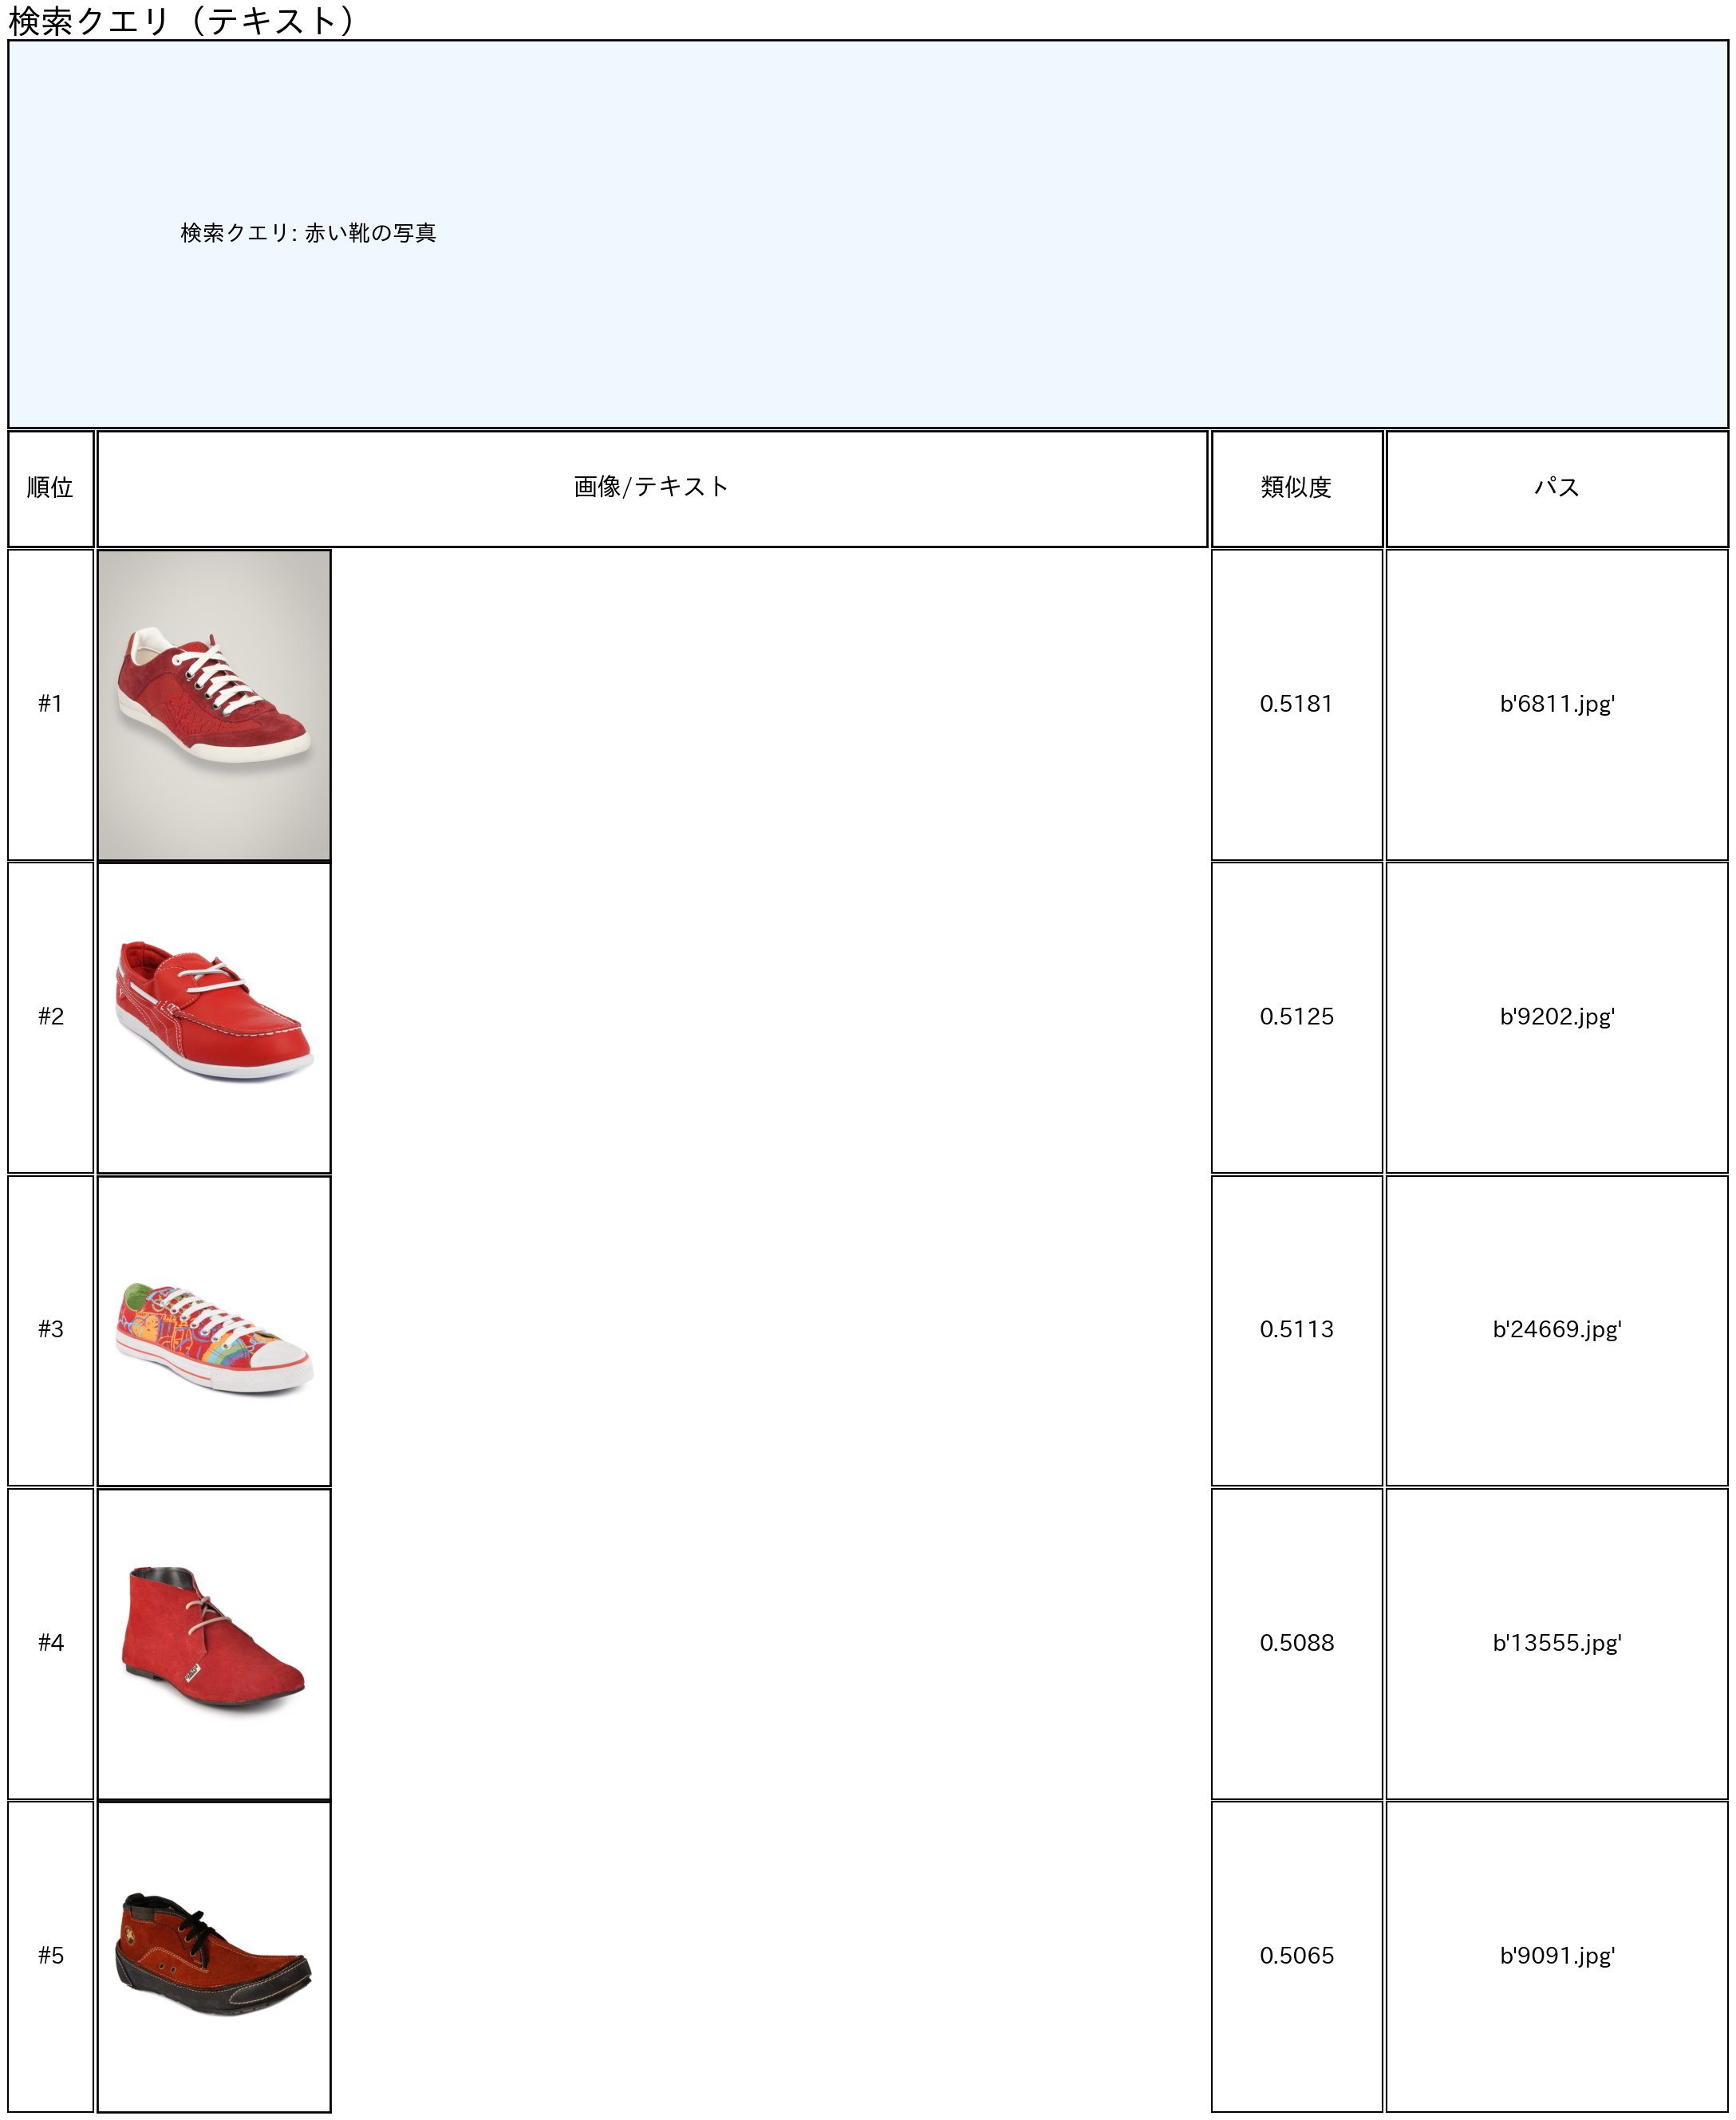

In [17]:
# 検索結果を画像付きで表示
display_search_results_with_df(results_df, max_images=5, query=query[0])

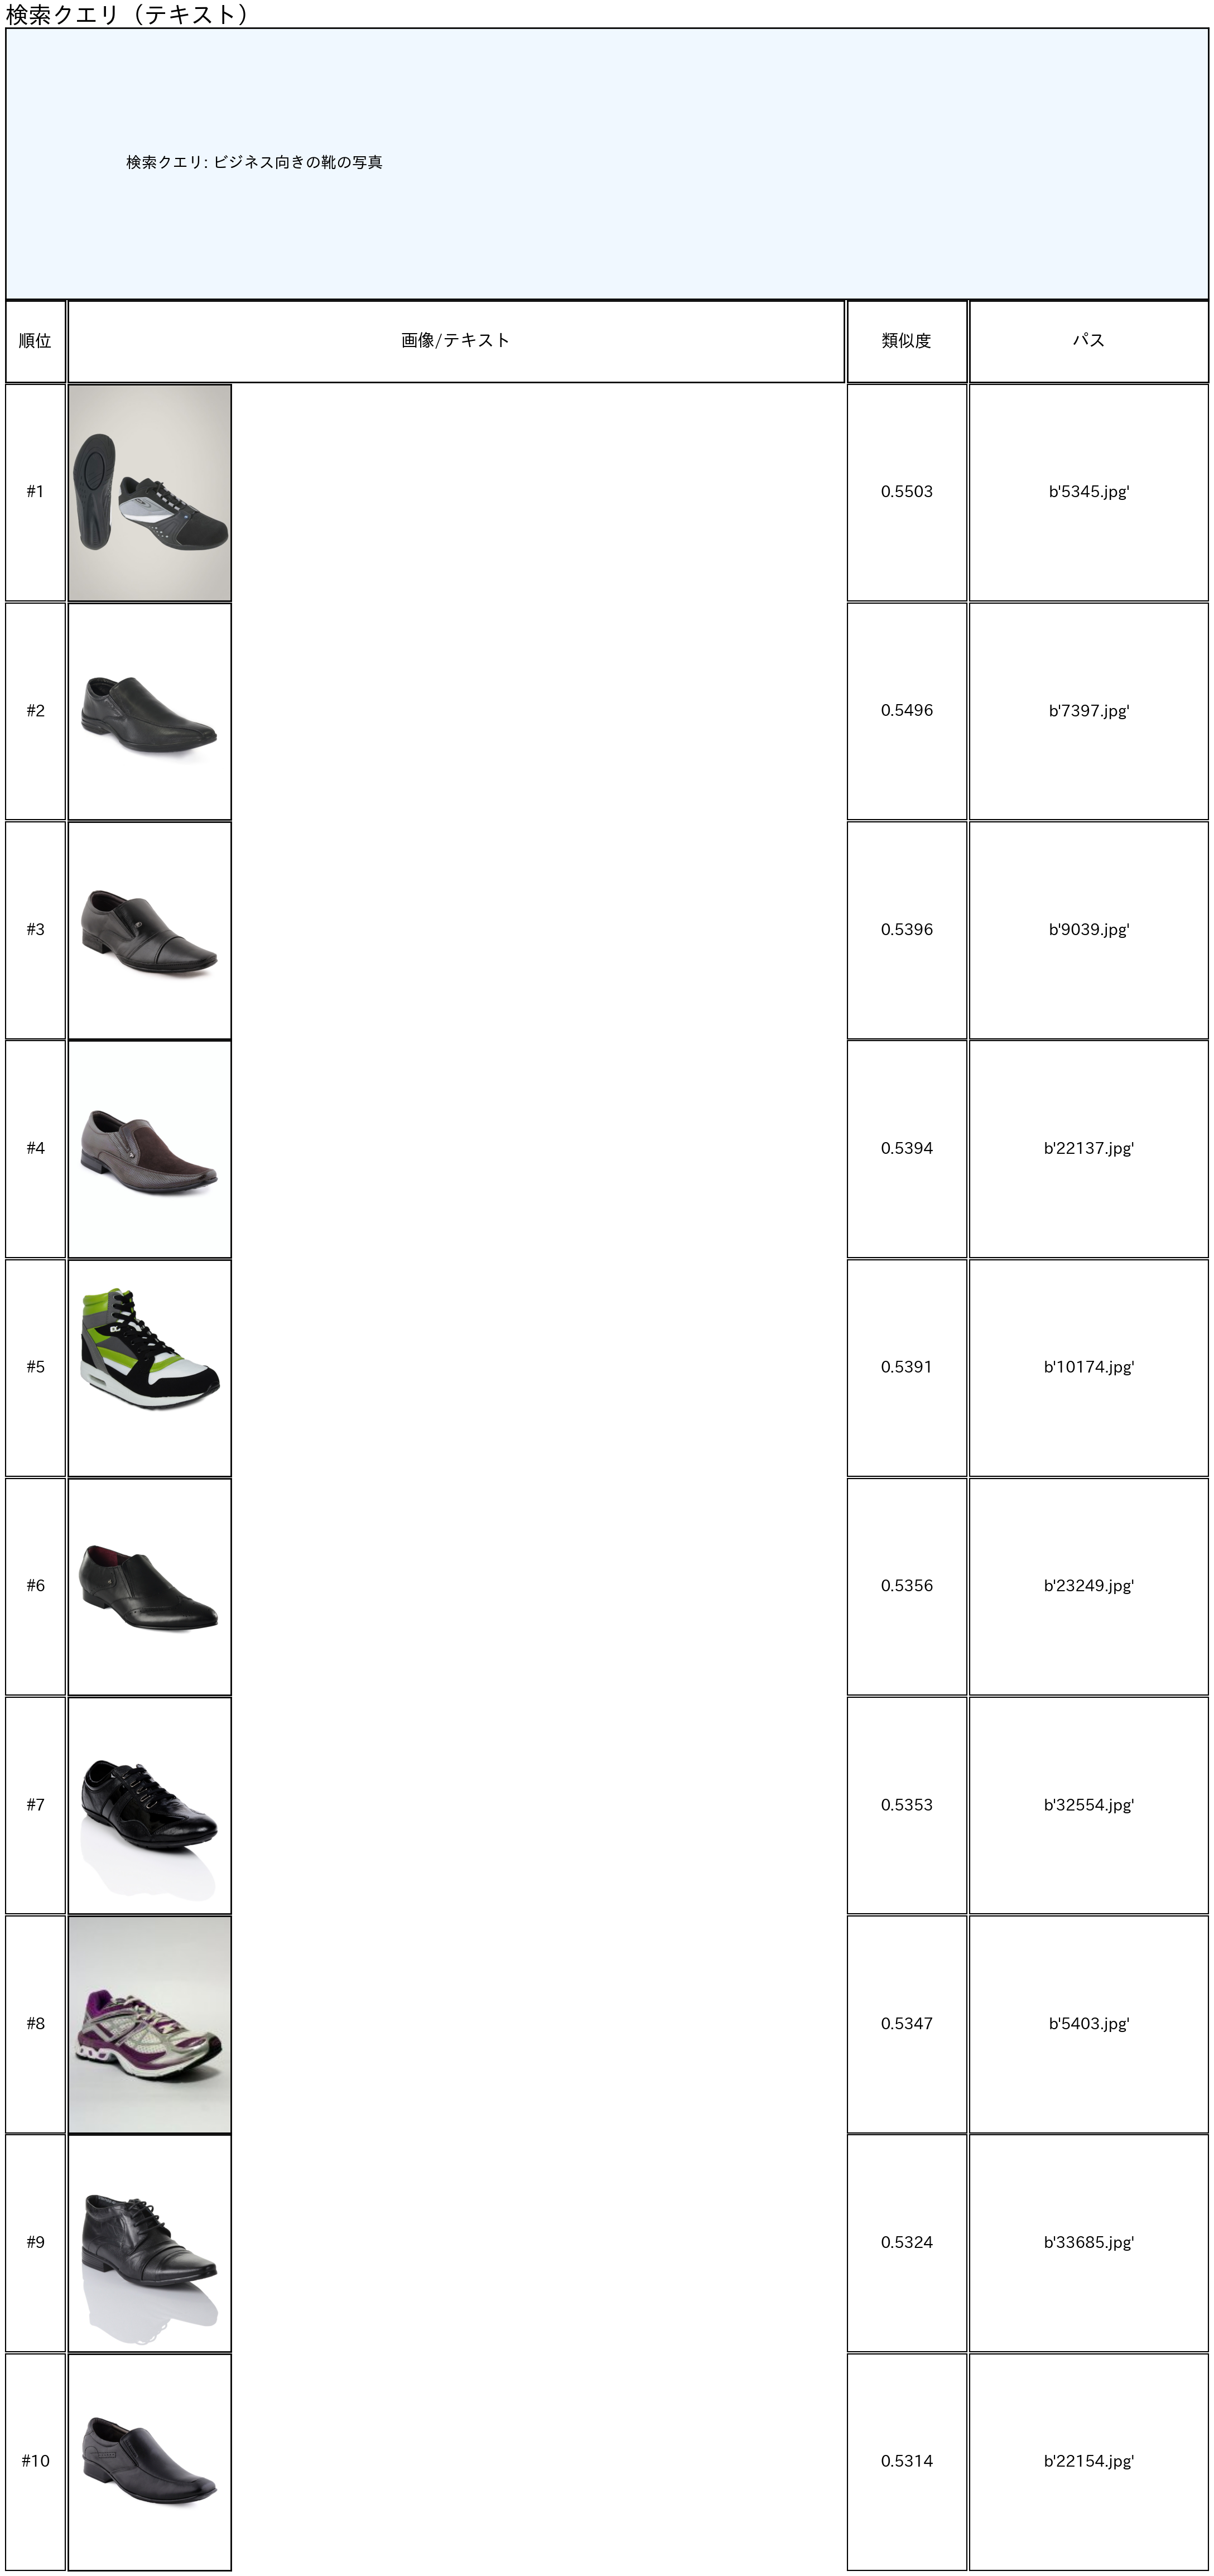

In [18]:
query = ["ビジネス向きの靴の写真"]
query_embedding = embed_query_text(query)
results_df = ranking(query_embedding, doc_embeddings)
display_search_results_with_df(results_df, max_images=10, query=query[0])

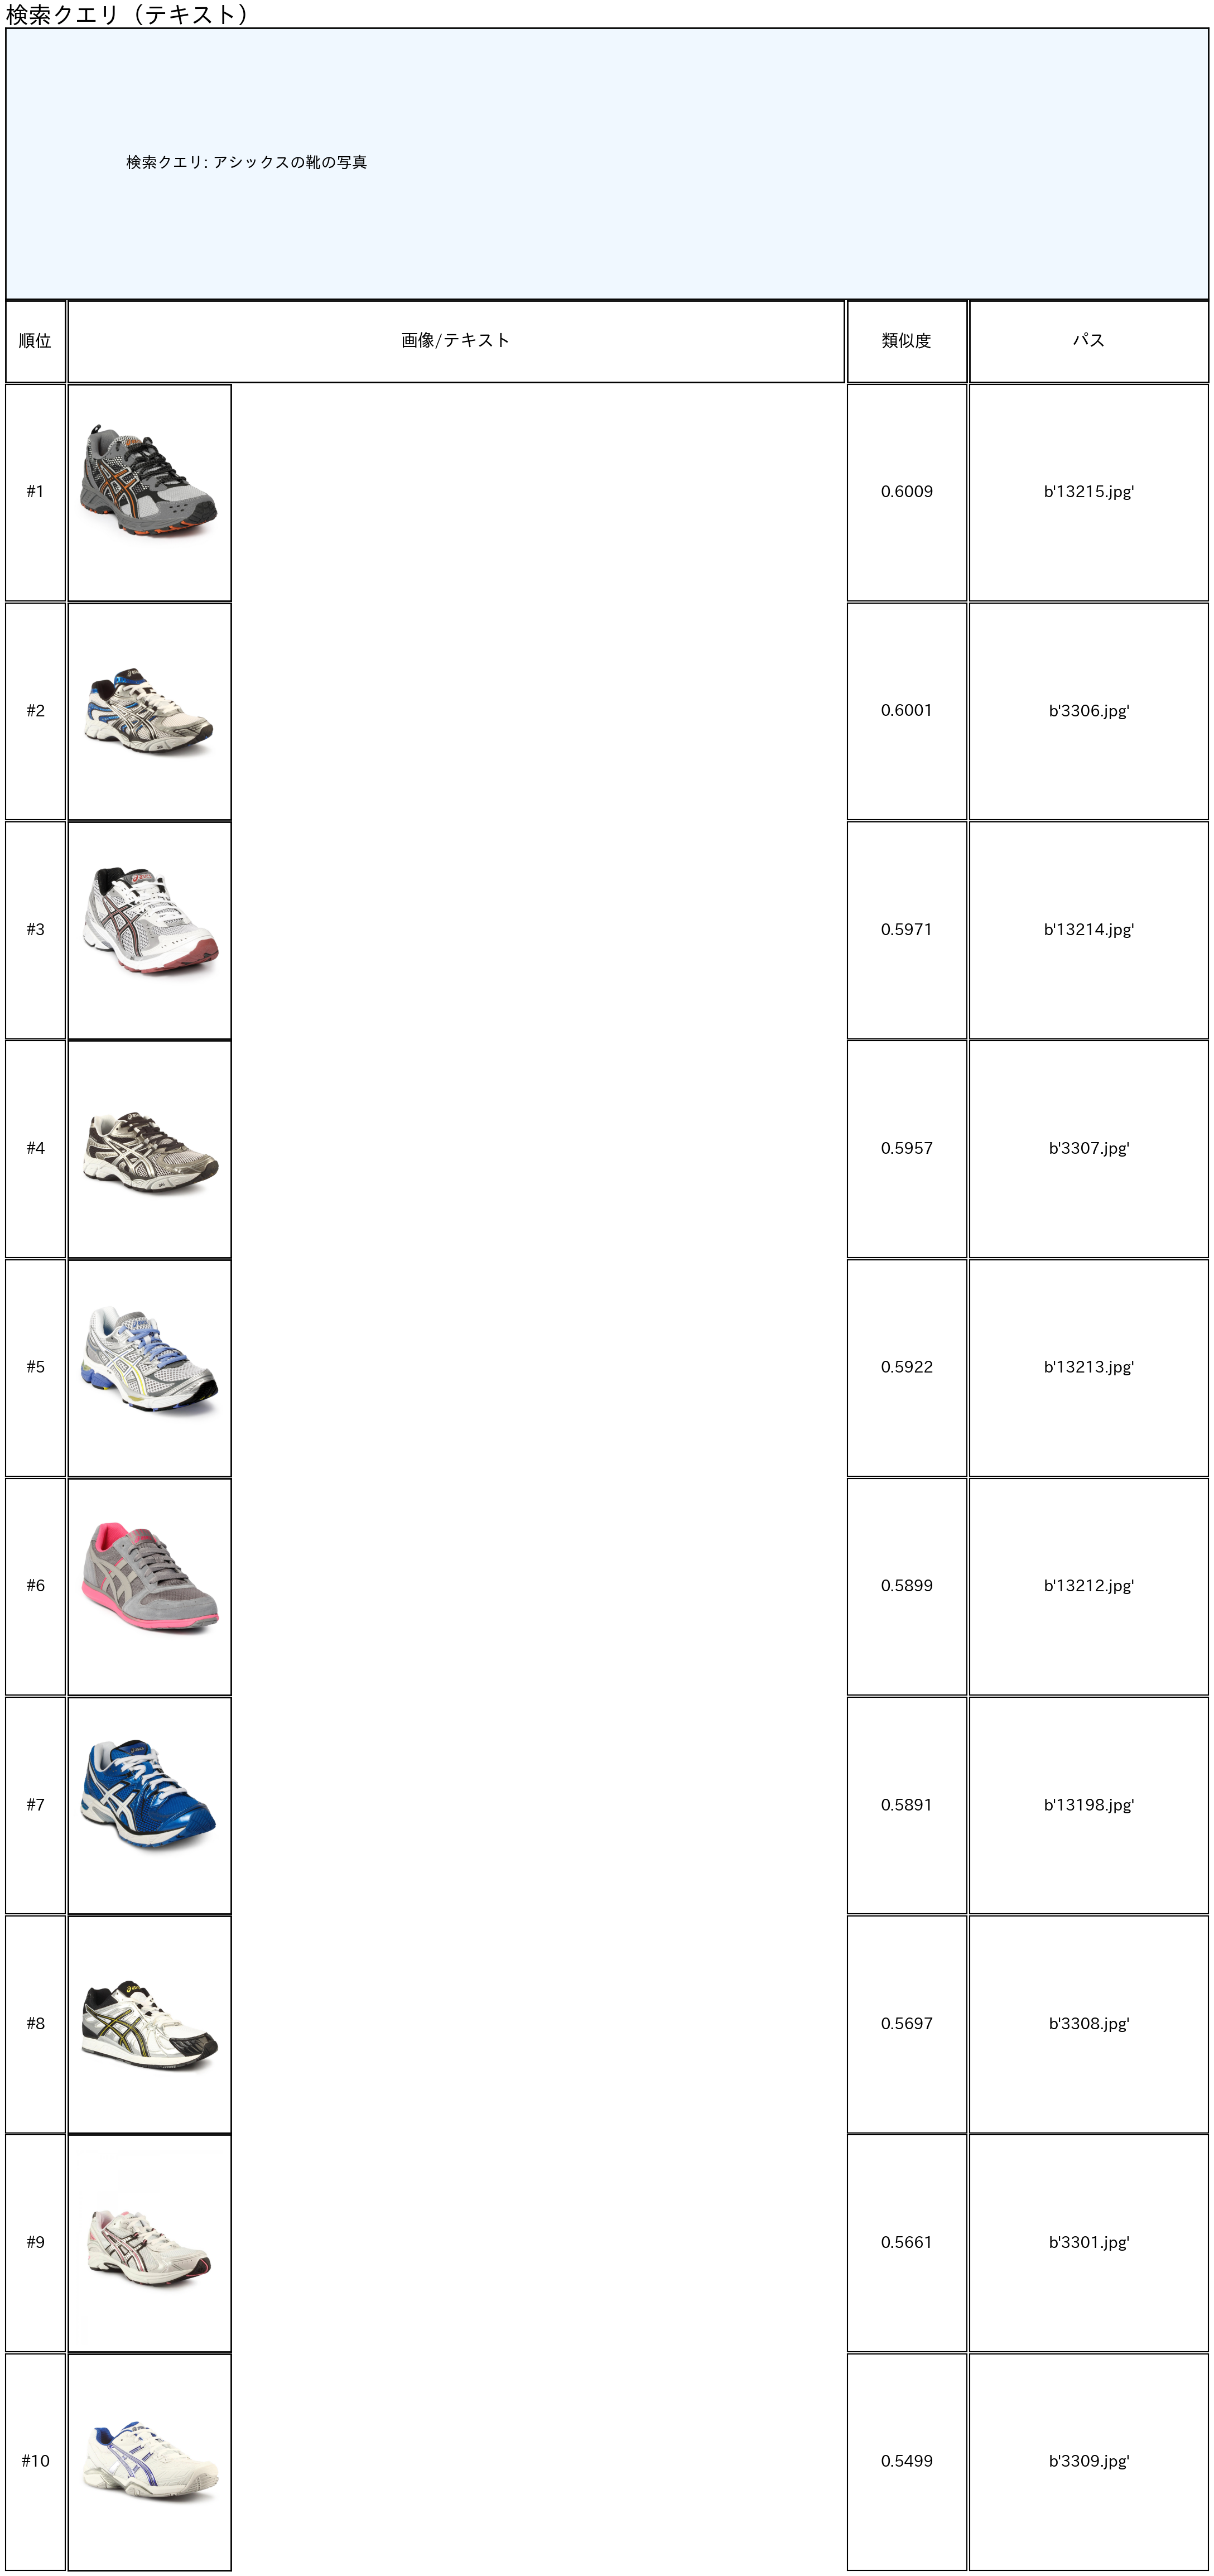

In [19]:
query = ["アシックスの靴の写真"]
#query = ["ニューバランスの靴の写真"]
#query = ["ナイキの靴の写真"]
query_embedding = embed_query_text(query)
results_df = ranking(query_embedding, doc_embeddings)
display_search_results_with_df(results_df, max_images=10, query=query[0])

## 画像検索（2） - 画像をクエリーとした画像の検索

### クエリー画像の埋め込み生成

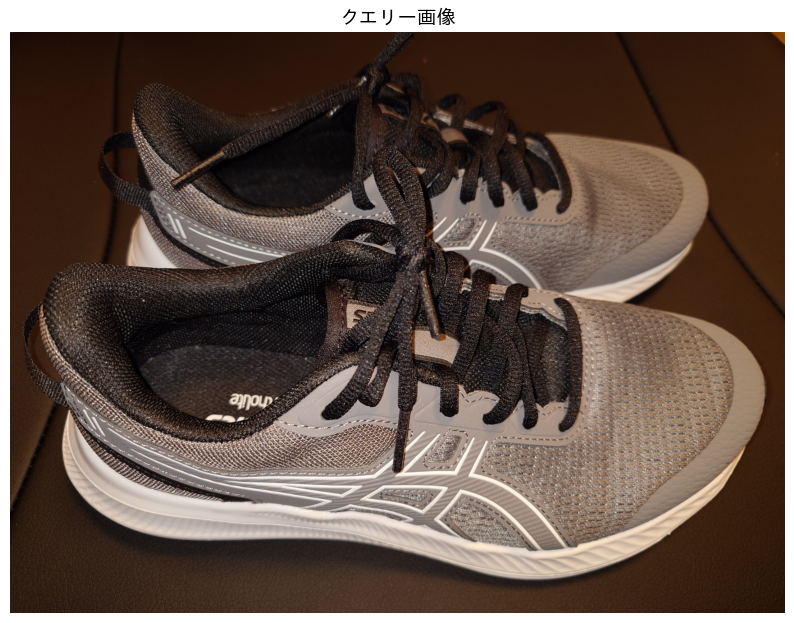

In [20]:
query_image_path = Path("ecimages/Footwear-dev/Women/Images/images_with_product_ids/2610.jpg").as_posix()
query_image_path = Path("20250322_155131.JPG").as_posix()
query_image_path = Path("20250322_223652.JPG").as_posix()
img = Image.open(query_image_path)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.title(f"クエリー画像", fontweight='bold', fontsize=14)
plt.axis('off')
plt.show()

In [21]:
def embed_query_image(query_image_path):
    data_url = image_to_base64_data_url(query_image_path)
    ret = co.embed(
        images=[data_url],
        input_type="image",
        model="embed-multilingual-v3.0",
        embedding_types=["float"],
    )
    return ret.embeddings.float

### クエリー画像による画像検索の実行

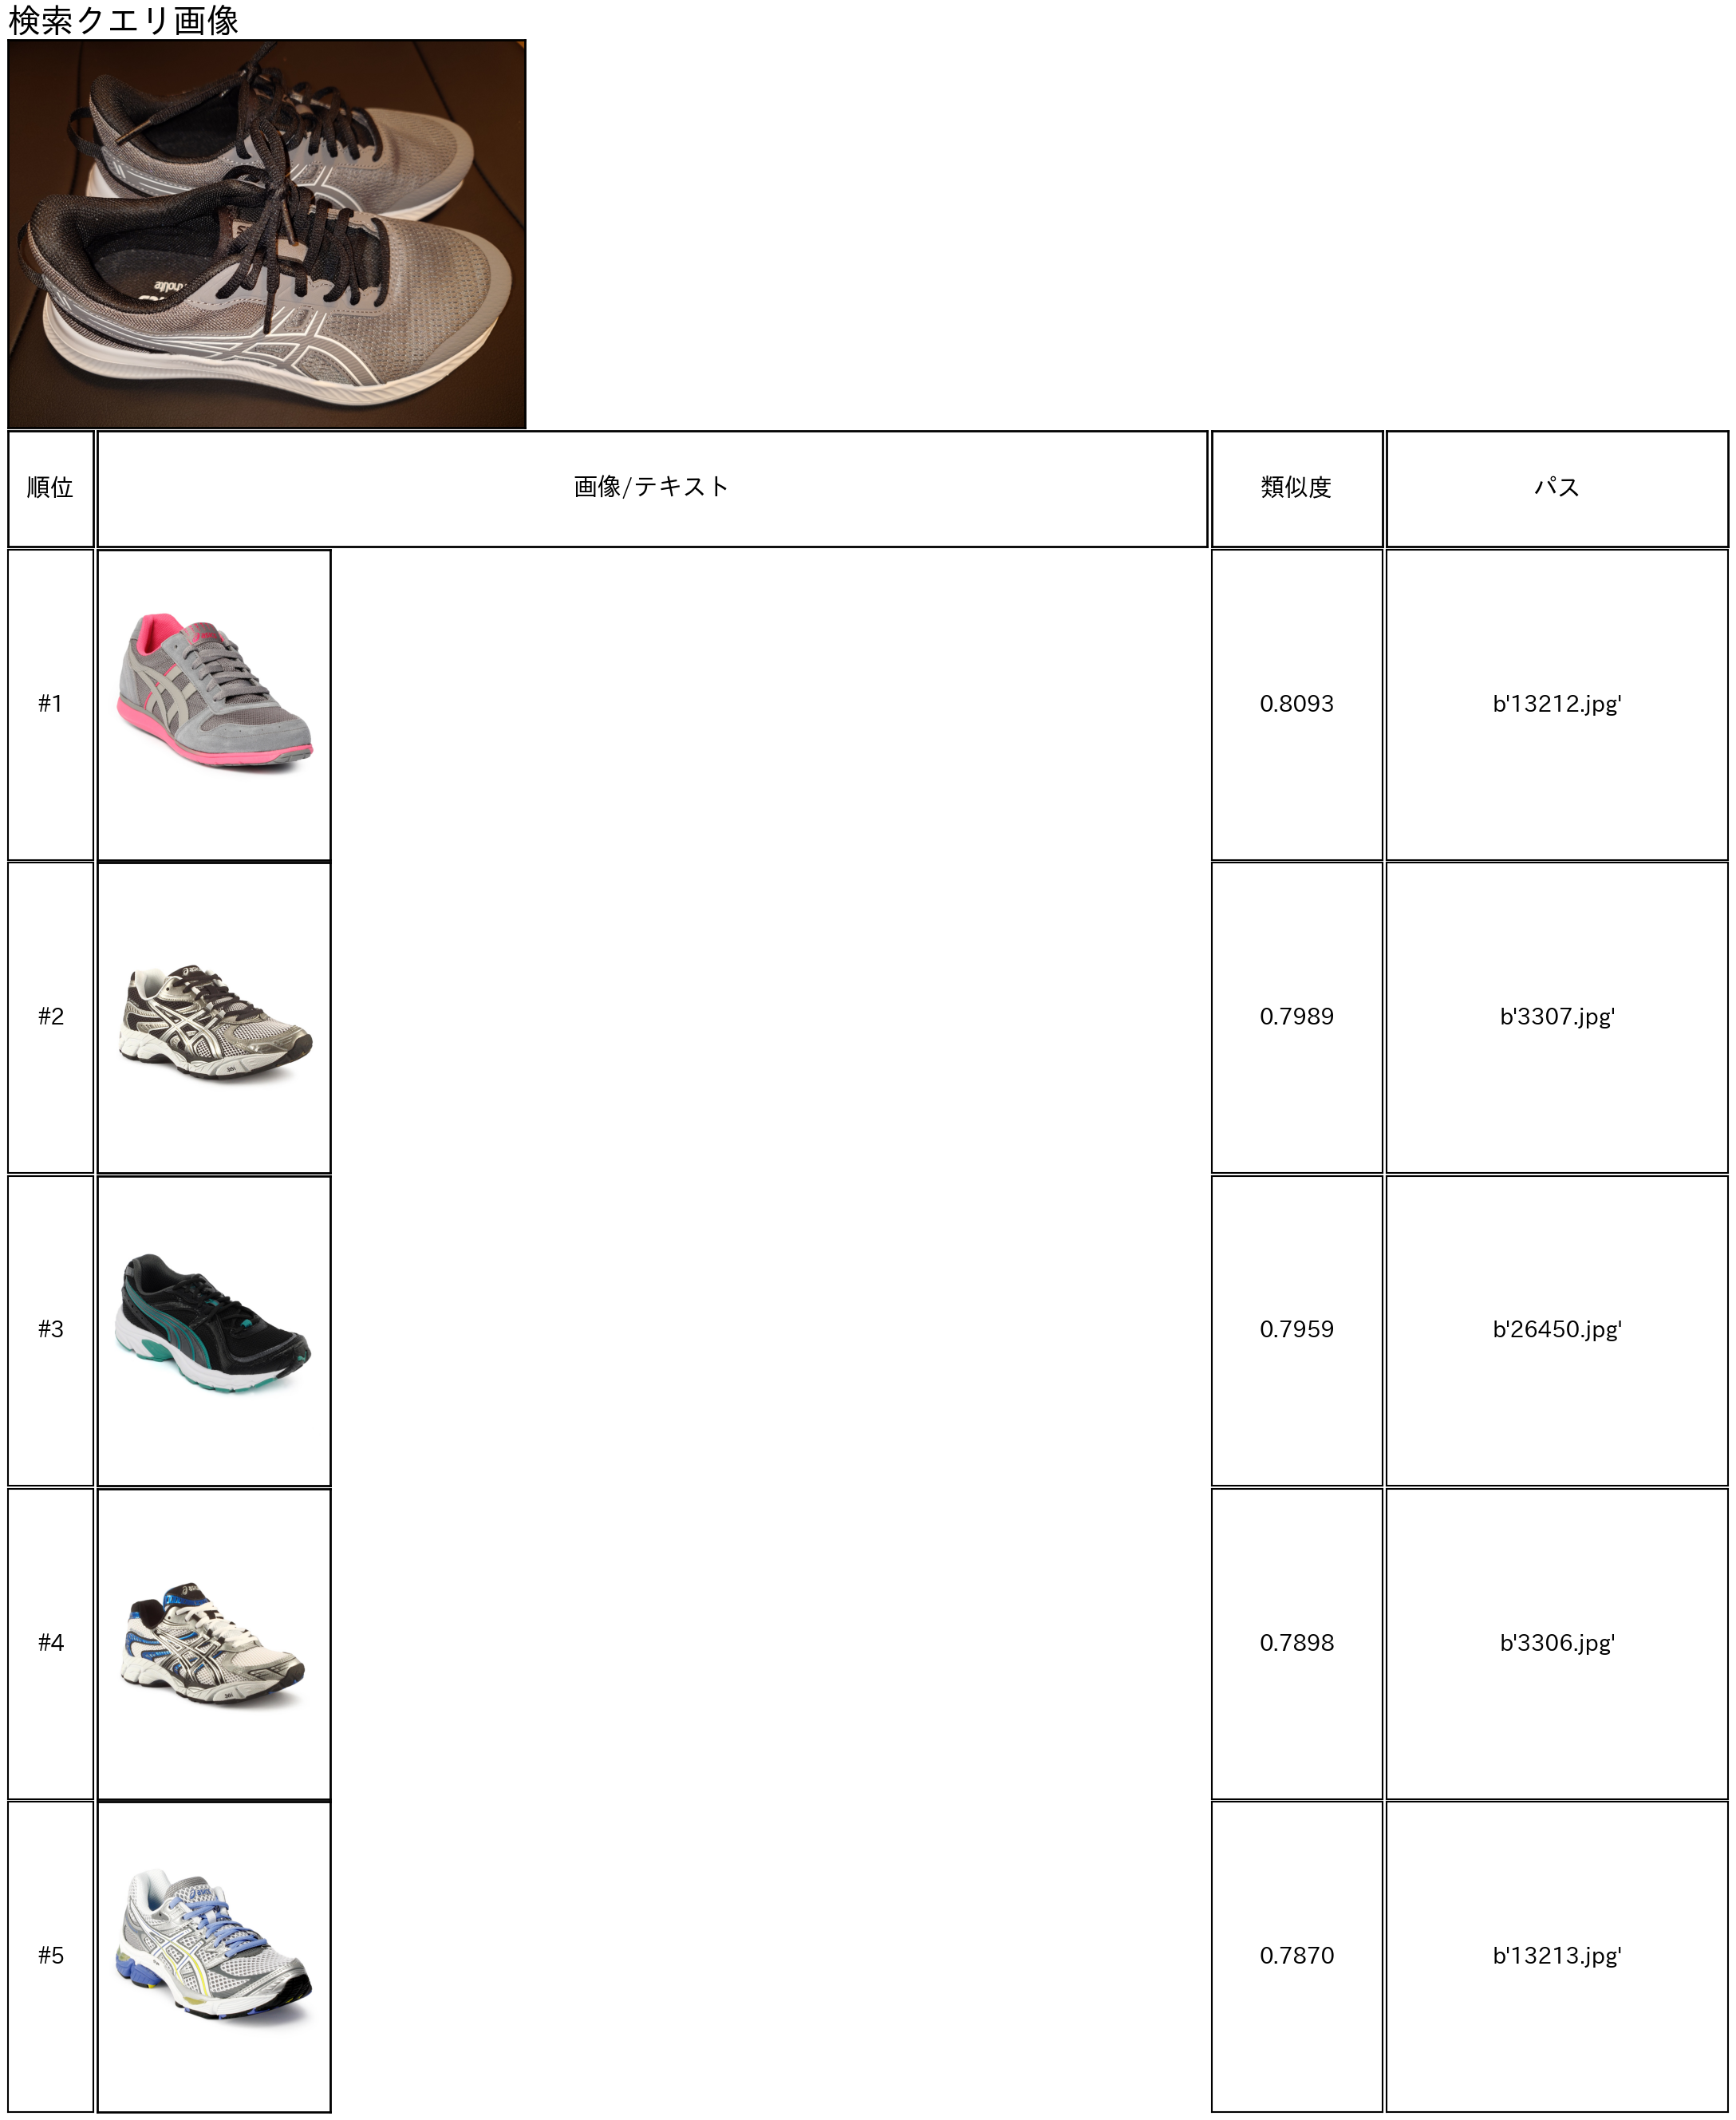

In [22]:
query_embedding = embed_query_image(query_image_path)
results_df = ranking(query_embedding, doc_embeddings)
display_search_results_with_df(results_df, max_images=5, query=query_image_path)